In [1]:
!nvidia-smi

Thu Jan 30 04:02:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0  On |                  N/A |
| 29%   29C    P8    17W / 250W |  10976MiB / 10988MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 29%   28C    P8    11W / 250W |  10652MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense, Conv2DTranspose, Dropout, Reshape, Flatten, UpSampling2D
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist, cifar10, fashion_mnist
from keras.losses import mse

from scipy.io import loadmat

import train, costs, pairs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

debug = False

if debug:
    from tensorflow.python import debug as tf_debug

    K.set_session(tf_debug.LocalCLIDebugWrapperSession(K.get_session()))

%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    pass

Using TensorFlow backend.


# DATASET AND USEFUL FUNCTION DEFINITIONS

In [3]:
def tf_get(input_tensors, output_tensors, input_data):
    input_data = input_data if isinstance(input_data, list) else [input_data]
    input_tensors, output_tensors = list(input_tensors), list(output_tensors)
    sess = K.get_session()
    return sess.run(output_tensors, dict(zip(input_tensors, input_data)))

In [4]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    shapes = [list(output_.get_shape()) for output_ in K_fn.outputs]
    shapes = [[len(x[0])] + s[1:] for s in shapes]
    y = [np.empty(s) for s in shapes]
    recon_means = []
    for i in range(int((x[0].shape[0]-1)/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def imscatter(x, y, samples, shape, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    m=samples.shape[0]
    i=0
    for x0, y0  in zip(x, y):
        im = OffsetImage(samples[i].reshape(shape), zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        i=i+1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, s2=None, alpha=0.5, alpha2=None, label1=None, label2=None, cmap1=None, cmap2=None, n_imgs=4, shuffle=True):
    s2 = s if s2 is None else s2
    alpha2 = alpha if alpha2 is None else alpha2
    
    if x.shape[1:] == (28, 28, 1) or x.shape[1:] == (32, 32, 3):
        x = x.reshape(len(x), -1)
    
    n = x.shape[1]
    
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s2, alpha=alpha2, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.set_axis_off()
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s2, alpha=alpha2, label=label2)
        g = (g, ax)
    elif n == 784 or n == 3072 or n == 24000:
        %matplotlib inline
        n_imgs = min(n_imgs, len(x))
        if n == 784:
            img_shape, wdist = (28, 28), -.7
        elif n == 3072:
            img_shape, wdist = (32, 32, 3), -.7
        elif n == 24000:
            img_shape, wdist = (100, 80, 3), -.785
        
        if x2 is None:
            g, axarr = plt.subplots(n_imgs, n_imgs)
            if shuffle:
                p = np.random.permutation(len(x))
            else:
                p = np.arange(len(x))
            n = 0
            while n < n_imgs * n_imgs:
                i, j = int(n / n_imgs), n % n_imgs
                axarr[i,j].axis('off')
                if n < len(x):
                    axarr[i,j].imshow(x[p[n]].reshape(img_shape))
                n += 1
        elif x2 is not None:
            p = np.random.permutation(len(x))[:n_imgs]
            for i in range(n_imgs):
                idx = p[i]
                plt.subplot(1,2,1)
                plt.imshow(x2[idx].reshape(img_shape))
                plt.subplot(1,2,2)
                plt.imshow(x[idx].reshape(img_shape))
                g = plt.figure()
        g.subplots_adjust(wspace=wdist, hspace=0)
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s2, alpha=alpha2, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [7]:
def generate_bunny(n=2000, train_set_fraction=.8):
    import bunny
    a = [np.expand_dims(np.array(bunny.trace2[c]), axis=-1) for c in ['x', 'y', 'z']]
    x = np.concatenate(a, axis=-1)
    x = x.astype(np.float32)
    x = x[np.logical_not(np.any(np.isnan(x), axis=1))]
    y = np.arange(len(x))
    
    return shuffle_and_return_n(x, y, train_set_fraction, n=n)

def generate_sphere(n=1200, train_set_fraction=.8):
    r = 1
    alpha = 4.0*np.pi*r*r/(n+1)
    d = np.sqrt(alpha)
    m_nu = int(np.round(np.pi/d))
    d_nu = np.pi/m_nu
    d_phi = alpha/d_nu
    count = 0
    coords = [[], [], []]
    y = []
    for i in range(0, m_nu):
        nu = np.pi*(i+0.5)/m_nu
        m_phi = int(np.round(2*np.pi*np.sin(nu)/d_phi))
        for j in range(0, m_phi):
            phi = 2*np.pi*j/m_phi
            xp = r*np.sin(nu)*np.cos(phi)
            yp = r*np.sin(nu)*np.sin(phi)
            zp = r*np.cos(nu)
            coords[0].append(xp)
            coords[1].append(yp)
            coords[2].append(zp)
            y.append(i + j)
            count = count +1
            
    x = np.array(coords).T
    y = np.array(y).T
        
    return shuffle_and_return_n(x, y, train_set_fraction, n=n)

def generate_plane(n=1200, train_set_fraction=.8):
    # compute number of points in each dimension
    n_i = np.int(np.sqrt(n))
    n = n_i ** 2
    
    # compute points on this grid
    t = np.mgrid[0:1:1/n_i, 0:1:1/n_i].reshape(2,-1).T
    t = np.concatenate([t, np.zeros(shape=(len(t),1))], axis=1)
    
    # compute rotation
    A = np.random.normal(size=(3, 3))
    A, _ = np.linalg.qr(A)
    
    x = np.dot(A, t.T).T
    
    # y is the sum of the ts
    y = t[:,0] + t[:,1]
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_circle(n=1000, train_set_fraction=.8, alpha=4):
    t = np.linspace(0, 2*np.pi, num=n+1)[:-1]
#     t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_faces(train_set_fraction=.8):
    x = np.array(loadmat('frey_rawface.mat')['ff']).T
    y = np.arange(len(x)) / len(x)
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_bulldog(train_set_fraction=.8):
    x = np.load('BuldogBig.npy').T
    y = np.arange(len(x))
    print(x.shape)
    
    x = x / np.max(x)
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def generate_gaussian_grid(train_set_fraction=.8):
    dim = 2
    n_per_gaussian = 300
    scale = .1
    xs = []
    ys = []
    for i in range(5):
        for j in range(5):
            loc = i - 2, j - 2
            xs.append(np.random.normal(loc=loc, scale=scale, size=(n_per_gaussian, dim)))
            ys.append([(i * 5) + j] * n_per_gaussian)
    x = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    
    return shuffle_and_return_n(x, y, train_set_fraction)

def shuffle_and_return_n(x, y, train_set_fraction, n=None):
    if n is None:
        n = len(x)
    # shuffle
    p = np.random.permutation(len(x))[:n]
    y = y[p]
    x = x[p]
    
    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()
    
    return (x_train, y_train), (x_test, y_test)

In [8]:
# embed data
def embed_data(x, dset):
    '''
    Convenience function: embeds x into the code space using the corresponding
    autoencoder (specified by dset).
    '''
    if not len(x):
        return np.zeros(shape=(0, 10))
    if dset == 'reuters':
        dset = 'reuters10k'

    json_path = '../pretrain_weights/ae_{}.json'.format(dset)
    weights_path = '../pretrain_weights/ae_{}_weights.h5'.format(dset)

    with open(json_path) as f:
        pt_ae = model_from_json(f.read())
    pt_ae.load_weights(weights_path)

    x = x.reshape(-1, np.prod(x.shape[1:]))

    get_embeddings = K.function([pt_ae.input],
                                  [pt_ae.layers[3].output])

    get_reconstruction = K.function([pt_ae.layers[4].input],
                                  [pt_ae.output])
    x_embedded = predict_with_K_fn(get_embeddings, x)[0]
    x_recon = predict_with_K_fn(get_reconstruction, x_embedded)[0]
    reconstruction_mse = np.mean(np.square(x - x_recon))
    print("using pretrained embeddings; sanity check, total reconstruction error:", np.mean(reconstruction_mse))

    del pt_ae

    return x_embedded

In [9]:
dataset = 'mnist'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
elif dataset == 'fmnist':
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
elif dataset == 'mnist_conv':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = np.expand_dims(x_train, -1) / 255
    x_test = np.expand_dims(x_test, -1) / 255 
    latent_dim = 10
elif dataset == 'fmnist_conv':
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # reshape and standardize x arrays
    x_train = np.expand_dims(x_train, -1) / 255
    x_test = np.expand_dims(x_test, -1) / 255 
    latent_dim = 10
if dataset == 'cifar10_conv':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train / 255
    x_test = x_test / 255 
    y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)
    latent_dim = 20
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=2, train_set_fraction=0.85)
    latent_dim = 5
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.01, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=1024, train_set_fraction=0.85, alpha=30)
    latent_dim = 2
elif dataset == 'plane':
    (x_train, y_train), (x_test, y_test) = generate_plane()
    latent_dim = 3
elif dataset == 'sphere':
    (x_train, y_train), (x_test, y_test) = generate_sphere(n=2000)
    latent_dim = 4
elif dataset == 'bunny':
    (x_train, y_train), (x_test, y_test) = generate_bunny(n=20000)
    latent_dim = 3
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 2
elif dataset == 'gaussian_grid':
    (x_train, y_train), (x_test, y_test) = generate_gaussian_grid()
    latent_dim = 30

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}, shape {} {}'.format(np.max(x_train), np.min(x_train), x_train.shape, x_test.shape))

if 'conv' in dataset:
    arch = [
        {'type': 'Conv2D', 'channels': 64, 'strides':(1,1), 'kernel':4},
        {'type': 'Conv2D', 'channels': 64, 'strides':(1,1), 'kernel':4},
        {'type': 'MaxPooling2D', 'pool_size': 2},
        {'type': 'Conv2D', 'channels': 64, 'strides':(1,1), 'kernel':4},
        {'type': 'Conv2D', 'channels': 64, 'strides':(1,1), 'kernel':4},
        {'type': 'MaxPooling2D', 'pool_size': 2},
#         {'type': 'Dropout', 'rate': 0.8},
        {'type': 'Flatten'},
        {'type': 'relu', 'size': 1024},
        {'type': 'relu', 'size': 1024},
        {'type': 'relu', 'size': 512},
        {'type': 'linear', 'size': latent_dim},
        ]
else:
#     arch = [
#         {'type': 'relu', 'size': 500},
#         {'type': 'linear', 'size': latent_dim},
#         ]
    arch = [
            {'type': 'relu', 'size': 1024},
            {'type': 'relu', 'size': 1024},
            {'type': 'relu', 'size': 512},
            {'type': 'relu', 'size': 10},
            ]

IMPORTANT: max 1.0, min 0.0, shape (60000, 784) (10000, 784)


# MODEL DEFINITIONS

In [10]:
class SiameseNet:
    def __init__(self, inputs, arch, siam_reg, y_true):
        self.orig_inputs = inputs
        # set up inputs
        self.inputs = {
                'A': inputs['Unlabeled'],
                'B': Input(shape=inputs['Unlabeled'].get_shape().as_list()[1:]),
                'Labeled': inputs['Labeled'],
                }

        self.y_true = y_true

        # generate layers
        self.layers = []
        self.layers += make_layer_list(arch, 'siamese', siam_reg)

        # create the siamese net
        self.outputs = stack_layers(self.inputs, self.layers)

        # add the distance layer
        self.distance = Lambda(costs.euclidean_distance, output_shape=costs.eucl_dist_output_shape)([self.outputs['A'], self.outputs['B']])

        #create the distance model for training
        self.net = Model([self.inputs['A'], self.inputs['B']], self.distance)

        # compile the siamese network
        self.net.compile(loss=costs.get_contrastive_loss(m_neg=1, m_pos=0.05), optimizer='rmsprop')

    def train(self, pairs_train, dist_train, pairs_val, dist_val,
            lr, drop, patience, num_epochs, batch_size):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.net.optimizer.lr,
                patience=patience)

        # initialize the training generator
        train_gen_ = train_gen(pairs_train, dist_train, batch_size)

        # format the validation data for keras
        validation_data = ([pairs_val[:, 0], pairs_val[:, 1]], dist_val)

        # compute the steps per epoch
        steps_per_epoch = int(len(pairs_train) / batch_size)

        # train the network
        hist = self.net.fit_generator(train_gen_, epochs=num_epochs, validation_data=validation_data, steps_per_epoch=steps_per_epoch, callbacks=[self.lh])

        return hist

    def predict(self, x, batch_sizes):
        # compute the siamese embeddings of the input data
        return train.predict(self.outputs['A'], x_unlabeled=x, inputs=self.orig_inputs, y_true=self.y_true, batch_sizes=batch_sizes)

In [11]:
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'tanh',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            y_ = tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0)
        else:
            y_ = self.outputs['Unlabeled']

        if self.normalized:
            y_ = y_ / tf.reduce_sum(W, axis=1)

        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)

        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]

    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.outputs['Unlabeled'],
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [12]:
# class SpectralNet:
#     def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
#             n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
#             siamese_net=None, x_train=None, have_labeled=False, eps=1e-7):
#         self.y_true = y_true
#         self.y_train_labeled_onehot = y_train_labeled_onehot
#         self.eps = eps
#         self.inputs = inputs
#         self.batch_sizes = batch_sizes
#         self.normalized = normalized
#         # generate layers
#         self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
#         self.layers += [
#                   {'type': 'linear',
#                    'size': n_clusters,
#                    'l2_reg': spec_reg,
#                    'name': 'spectral_{}'.format(len(arch)-1)},
#                   {'type': 'Orthonorm', 'name':'orthonorm'}
#                   ]

#         # create spectralnet
#         self.outputs = stack_layers(self.inputs, self.layers)
#         self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

#         # DEFINE LOSS

#         # generate affinity matrix W according to params
#         if siamese_net is not None:
#             input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
#             x_affinity = siamese_net.predict(x_train, batch_sizes)
#         else:
#             input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
#             x_affinity = x_train

#         # calculate scale for affinity matrix
#         scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

#         # create affinity matrix
#         W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

#         y_ = self.outputs['Unlabeled']
            
#         if self.normalized:
#             # compute the row and column denominators
#             row_norm = 1 / tf.reduce_sum(W, axis=1)
#             col_norm = 1 / tf.reduce_sum(W, axis=0)
            
#             # apply them
#             W = tf.einsum('j,ij->ij', col_norm, tf.einsum('i,ij->ij', row_norm, W))
            
#             # compute D^{-1/2} and apply it
#             self.D_half_inv = dhv = tf.sqrt((1 / tf.reduce_sum(W, axis=1)) + self.eps)
#             W = tf.einsum('j,ij->ij', dhv, tf.einsum('i,ij->ij', dhv, W))
#             self.normalized_output = y_ * tf.expand_dims(dhv, -1)
        
#         self.Dy = costs.squared_distance(y_)

#         # define loss
#         self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

#         # create the train step update
#         self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
#         self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
# #         self.train_step = tf.train.AdamOptimizer().minimize(self.loss, var_list=self.net.trainable_weights)
        
#         # initialize spectralnet variables
#         K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

#     def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
#             lr, drop, patience, num_epochs):
#         # create handler for early stopping and learning rate scheduling
#         self.lh = LearningHandler(
#                 lr=lr,
#                 drop=drop,
#                 lr_tensor=self.learning_rate,
#                 patience=patience)

#         losses = np.empty((num_epochs,))
#         val_losses = np.empty((num_epochs,))

#         # begin spectralnet training loop
#         self.lh.on_train_begin()
#         i = 0
#         for i in range(num_epochs):
#             # train spectralnet
#             losses[i] = train.train_step(
#                     return_var=[self.loss],
#                     updates=self.net.updates + [self.train_step],
#                     x_unlabeled=x_train_unlabeled,
#                     inputs=self.inputs,
#                     y_true=self.y_true,
#                     batch_sizes=self.batch_sizes,
#                     x_labeled=x_train_labeled,
#                     y_labeled=self.y_train_labeled_onehot,
#                     batches_per_epoch=100)[0]

#             # get validation loss
#             val_losses[i] = train.predict_sum(
#                     self.loss,
#                     x_unlabeled=x_val_unlabeled,
#                     inputs=self.inputs,
#                     y_true=self.y_true,
#                     x_labeled=x_train_unlabeled[0:0],
#                     y_labeled=self.y_train_labeled_onehot,
#                     batch_sizes=self.batch_sizes)

#             # do early stopping if necessary
#             if self.lh.on_epoch_end(i, val_losses[i]):
#                 print('STOPPING EARLY')
#                 break

#             # print training status
#             print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

#         return losses[:i+1], val_losses[:i+1]
    
#     def predict(self, x):
#         # test inputs do not require the 'Labeled' input
#         inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm'], 'Labeled':self.inputs['Labeled']}
#         pred_tensor = self.normalized_output if self.normalized else self.outputs['Unlabeled']
#         return train.predict(
#                     pred_tensor,
#                     x_unlabeled=x,
#                     inputs=inputs_test,
#                     y_true=self.y_true,
#                     x_labeled=x[0:0],
#                     y_labeled=self.y_train_labeled_onehot[0:0],
#                     batch_sizes=self.batch_sizes)

In [13]:
def pick_nearest_k(D, k, drop_self=True, randomize=False):
            n_batch = tf.shape(D)[-1]
            if drop_self:
                _, idxs = tf.nn.top_k(-D, k=k+1)
                idxs = idxs[:,1:]
            else:
                _, idxs = tf.nn.top_k(-D, k=k)
            # create a random index 
            if randomize:
                range_D = tf.expand_dims(tf.range(n_batch * k), -1)
                p = tf.expand_dims(tf.random.uniform(shape=(n_batch * k,), maxval=k, dtype=tf.dtypes.int32), -1)
                p = tf.concat([range_D, p], axis=1)
                # draw from the top k values using this index
                idx = tf.expand_dims(tf.gather_nd(idxs, p), -1)
            else:
                print("IMPORTANT", idxs.shape)
                idx = tf.reshape(idxs, (n_batch * k, 1))
            
            return idx
        
class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, remove_dim=0, 
                 pca=True, alpha=1., normalize_factor=.1, k=16, eps=1e-5, lam=1e-1,
                 arch=[500], conv_decoder=False):
        optimizer = 'adam'
#         optimizer = RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        self.eps = eps
        self.lam = lam
        self.pca = pca
        self.alpha = float(alpha)
        self.k = k
        self.remove_dim = remove_dim
        self.conv_decoder = conv_decoder
        self.arch = arch
        
        if conv_decoder:
            print("USING CONVOLUTIONAL DECODER! CHECK OUTPUT SHAPE:", self.orig_dim)
        else:
            print("USING DENSE DECODER! FLATTENING OUTPUT SHAPE IF NOT ALREADY FLAT:", self.orig_dim, np.prod(self.orig_dim))
            self.orig_dim = np.prod(self.orig_dim)
        
        self.x = x = self.copy_spectralnet(spectralnet)
        
        #
        # DEFINE ALL LOSSES
        #
        def top_k_loss(D, k):
            # get nearest (i.e., largest negative distance) neighbors of each point
            vals, _ = tf.nn.top_k(-D, k=k)

            # remove self as neighbor, negate to get positive distances again
            vals = -vals
                
            return K.sum(vals)
        def kl_loss(_, __):
            log_e = 2 * self.half_log_e
            v = tf.reshape(self.v, (-1, self.latent_dim, self.latent_dim))
            # find local neighborhood of each point in batch
            D = self.pairwise_distances(self.z, self.z_mu)
            n_batch = tf.shape(D)[-1]
            idx = pick_nearest_k(D, self.k, drop_self=True)
            omn = z_mu_nb = tf.gather_nd(self.z_mu, idx)
            z_mu_nb = tf.reshape(z_mu_nb, shape=(n_batch, self.k, self.latent_dim))
            print("z_mu_nb", z_mu_nb.shape)
            
            # obtain covariance of each local neighborhood
            cov_nb = tf.einsum('ikj,ikl->ijl', z_mu_nb, z_mu_nb)
            cov_nb = tf.Print(cov_nb, [tf.shape(omn), tf.shape(z_mu_nb), omn[:self.k], z_mu_nb[0,:,:]], summarize=10)
            
            # obtain eigendecomposition of local neighborhood
            e_nb, v_nb = tf.linalg.eigh(cov_nb)
            e_nb += self.lam
            
            # take log (used in final loss) BEFORE truncating
            log_e_nb = tf.log(e_nb + self.eps)
            
            e_nb *= self.alpha
            
            # compute trace of Sigma_cov^{-1} Sigma_theta
            inv_sigma_nb = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v_nb, 1 / e_nb), v_nb)
            
            sigma_vae = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v, self.e), v)
            half_prod = tf.einsum('ikj,ikl->ijl', inv_sigma_nb, sigma_vae)
            trace = tf.linalg.svd(half_prod, compute_uv=False)
            
            # compute KL divergence
            self.kl_loss = tf.reduce_sum(log_e_nb - log_e - 1 + trace)
            return self.kl_loss
        def pca_loss(_, __):
            if self.pca:
                self.pca_loss = K.sum(mse(self.pca_input, self.pca_recon)) * np.prod(self.orig_dim)
            else:
                self.pca_loss = tf.constant(0.)
            return self.pca_loss
        def neighborhood_loss(_, __):
            # involves two bursts, on-manifold burst and off-manifold burst
            z = self.z
            x_recon = self.x_recon
            
            # obtain pairwise distances (size(recon) x size(input))
            D = self.pairwise_distances(z, self.z_mu)
            n_batch = tf.shape(D)[-1]
            idx = pick_nearest_k(D, self.k, drop_self=True)
            
            # now compute neighborhood
            orig_dim = np.prod(self.orig_dim)
            data_flat_shape = (-1, np.prod(self.orig_dim))
            input_ = tf.reshape(self.input, data_flat_shape)
            print("important input shape", input_.shape)
            input_neighborhood = tf.gather_nd(input_, idx)
            x_recon_flattened_expanded = tf.reshape(x_recon, data_flat_shape + (1,))
            x_recon = tf.reshape(tf.tile(x_recon_flattened_expanded, [1, self.k, 1]), data_flat_shape)
            print("NEIGHBORHOOD AND RECON SHAPES:", input_neighborhood.shape, x_recon.shape)
            self.neighborhood_loss = tf.reduce_sum(mse(input_neighborhood, x_recon)) / self.k
            
            return self.neighborhood_loss
        def vae_loss(_, __):
            return self.loss
        
        #
        # DEFINE LAYERS
        #

        # create encoder
        self.x_enc = x_enc = self.build_encoder(x, arch=self.arch, remove_dim=remove_dim, pca=self.pca)
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        self.x_recon = x_recon = self.build_decoder(x_enc, arch=self.arch)
        self.decoder_input = Input(shape=(self.latent_dim,), name='UnlabeledInput')
        self.decoder_output = self.build_decoder(self.decoder_input, arch=self.arch)
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)
        
        # create normalized decoder
        x_enc_norm = self.build_encoder(x, arch=self.arch, normalize_cov=normalize_factor, pca=self.pca)
        self.x_recon_norm = self.build_decoder(x_enc_norm, arch=self.arch)
        
        if self.pca:
            self.pcae = Model(inputs=self.input, outputs=self.pca_recon)
            self.pc = Model(inputs=self.input, outputs=self.pc_embedding)
            self.pcae.compile(optimizer=optimizer, loss=pca_loss)
            
        #
        # COMPUTE LOSS
        #
        losses = [kl_loss, pca_loss, neighborhood_loss]
        self.init_losses = [l(None, None) for l in losses]
        loss_weights = [1, 0, 1]
        # initialize losses
        self.loss = sum([a * b if b != 0 else K.constant(0.) for a, b in zip(self.init_losses, loss_weights)])
        
        #
        # ASSEMBLE NETWORK
        #
        self.vae = Model(inputs=self.input, outputs=self.x_recon)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def pairwise_distances(self, A, B):
        r_A, r_B = tf.reduce_sum(A*A, 1), tf.reduce_sum(B*B, 1)

        # turn r into column vector
        r_A, r_B = tf.reshape(r_A, [-1, 1]), tf.reshape(r_B, [-1, 1])
        D = r_A - 2 * tf.matmul(A, B, transpose_b=True) + tf.transpose(r_B)

        return D
        
    def build_decoder(self, x, arch):
        if not hasattr(self, 'decoder_layers'):
            if self.conv_decoder:
                in_channels = 1
                out_channels = 1 # int(self.input.shape[-1])
                pix = 28 # int(self.input.shape[-2])
                reshaped_dim = [int(pix / 4), int(pix / 4), in_channels]
                inputs_decoder = int(np.prod(reshaped_dim))
                keep_prob = 0.8
                self.decoder_layers = [
#                     Dense(inputs_decoder),
#                     LeakyReLU(),
#                     Dense(inputs_decoder * 2 + 1),
#                     LeakyReLU(),
#                     Reshape(reshaped_dim),
#                     Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', activation='relu'),
#                     Dropout(keep_prob),
#                     Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation='relu'),
#                     Dropout(keep_prob),
#                     Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation='relu'),
#                     Flatten(),
#                     Dense(np.prod(self.orig_dim)),
#                     LeakyReLU(),
                    Dense(int(inputs_decoder / 2)),
                    LeakyReLU(),
                    Dense(inputs_decoder),
                    LeakyReLU(),
                    Reshape(reshaped_dim),
                    Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation='relu'),
                    Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation='relu'),
                    UpSampling2D(),
                    Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation='relu'),
                    Conv2DTranspose(filters=out_channels, kernel_size=4, strides=1, padding='same', activation='relu'),
                    UpSampling2D(),
                    Reshape([pix * pix * out_channels]),
#                     Dense(np.prod(self.orig_dim)),
#                     LeakyReLU(),
                    
                    ]
            else:
                self.decoder_layers = [Dense(a, activation='relu') for a in arch]
                self.decoder_layers.append(Dense(self.orig_dim, activation='linear'))

        xs = [x]
        for l in self.decoder_layers:
            xs.append(l(xs[-1]))
#             x = l(x)
        x = xs[-1]
        self.decoder_xs = xs
        return x
        
    def build_encoder(self, x, arch, pca=False, normalize_cov=False, no_noise=False, remove_dim=0):
        if pca and not hasattr(self, 'pca_layers'):
            self.pca_layers = [Dense(self.latent_dim, activation='linear'), 
                               Dense(self.spectralnet_dim, activation='linear')]
            
        if not hasattr(self, 'encoder_layers'):
            self.encoder_precov_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_precov_layers.append(Dense(self.latent_dim * self.latent_dim, activation='linear'))
            self.encoder_eig_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_eig_layers.append(Dense(self.latent_dim, activation='linear'))
            
        # assemble pca layer (a linear autoencoder) and define mu (the latent embedding of this layer)
        if pca:
            if not hasattr(self, 'pca_input'):
                self.pca_input = x
            
            self.pc_embedding = x = self.pca_layers[0](x)

            if not hasattr(self, 'pca_recon'):
                self.pca_recon = self.pca_layers[1](x)

        # define mu (the latent embedding of the pca layer)
        mu = x
        if not hasattr(self, 'mu'):
            self.z_mu = mu
        
        x_precov = x
        # get covariance precursor
        for l in self.encoder_precov_layers:
            x_precov = l(x_precov)
            
        x_eig = x
        # get eigenvalues
        for l in self.encoder_eig_layers:
            x_eig = l(x_eig)
        
        # sample latent space (and normalize covariances if we're trying to do random walks)
        if not hasattr(self, 'encoder_sampling_layer'):
            f = partial(self.sampling, normalize_cov=normalize_cov, remove_dim=remove_dim)
            self.encoder_sampling_layer = Lambda(f, output_shape=(self.latent_dim,), name='z')
            
        if no_noise:
            cur_encoder_sampling_layer = Lambda(lambda x_: x_[0], output_shape=(self.latent_dim,))
            
        # get encoder embedding
        x_enc = self.encoder_sampling_layer([mu, x_precov, x_eig])
        
        return x_enc
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            l.trainable = False
            xs.append(l(xs[-1]))
            layers.append(l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.spectralnet_dim = int(x.get_shape()[1])
        if self.pca:
            print("PCA")
            self.latent_dim = self.spectralnet_dim - 1
        else:
            print("NO PCA")
            self.latent_dim = self.spectralnet_dim
            
        return x

    def sampling(self, args, normalize_cov, remove_dim):
        # get args
        z_mean, precov, e = args
        
        # reshape precov and compute cov = precov x precov.T
        cov = tf.reshape(precov, (-1, self.latent_dim, self.latent_dim))

        # perform eigendecomposition
        v, _ = tf.linalg.qr(cov)
        
        if not hasattr(self, 'e'):
            self.half_log_e, self.e, self.v = e, tf.exp(2 * e), tf.reshape(v, (-1, self.latent_dim * self.latent_dim))
            
        dim = self.latent_dim
        
        # get shapes
        batch = K.shape(z_mean)[0]
                
        # sample from normal distribution
        epsilon = K.random_normal(stddev=self.alpha, shape=(batch, K.int_shape(z_mean)[1]))
        
        # get sqrt covariance matrix stack
        sqrt_sigma = tf.einsum('ijk,ilk->ijl', tf.einsum('ijk,ik->ijk', v, tf.sqrt(self.e)), v)
        
        # multiply covariance matrix stack with random normal vector
        sqrt_sigma_epsilon = tf.einsum('ijk,ik->ij', sqrt_sigma, epsilon)
        
        if not hasattr(self, 'sqrt_sigma'):
            self.sqrt_sigma = tf.reshape(sqrt_sigma, (-1, self.latent_dim * self.latent_dim))
        
        # assembled output
        z = z_mean + sqrt_sigma_epsilon
        
        if not hasattr(self, 'z'):
            self.z = z
        
        return z

    def generate_from_samples(self, x, return_mu_sigma=False, normalize_cov=False):
        _x_recon = self.x_recon_norm if normalize_cov else self.x_recon
        get_fn = K.function([self.input], [_x_recon, self.z_mu, self.v, self.e, self.x_enc])
        x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = predict_with_K_fn(get_fn, x)
        if return_mu_sigma:
            return x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc
        else:
            return x_recon
        
    def train_pca(self, x_train, x_val=None, epochs=1, batch_size=128, patience=5):
        if x_val is not None:
            val_data = list((x_val, x_val))
        else:
            val_data = None
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
        
        self.pcae.fit(x=x_train, y=x_train, epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=[earlystop], verbose=2)
        
    def train(self, X_train, batch_size=128, epochs=100):      
        self.vae_loss = []
        last_cov = np.zeros((self.latent_dim, self.latent_dim))
        cov_x = X_train[np.random.randint(0, X_train.shape[0], 1)]
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            samples = X_train[idx]
            vae_loss = self.vae.train_on_batch([samples], [samples])
            self.vae_loss.append(vae_loss)

            if epoch % 25 == 0:
                # Plot the progress
                loss_names = ['kl_loss', 'pca_loss','neighborhood_loss']
                loss_string = "{} [VAE loss: {}] [" + ": {}] [".join(loss_names) + ": {}]"
                losses = self.init_losses
                loss_vals = K.get_session().run(losses, feed_dict={self.input: samples})
                print(loss_string.format(epoch, vae_loss, *loss_vals))
                
                # now get variance of the covariance vectors with respect to some fixed vector
                cov, val = K.get_session().run([self.v, self.e], feed_dict={self.input: cov_x})
                cov = cov.reshape((self.latent_dim, self.latent_dim))
                print('vector covariance:\n', cov.dot(last_cov.T))
                print(cov.T.dot(last_cov))
                print(val)
                last_cov = cov
                

# TRAINING

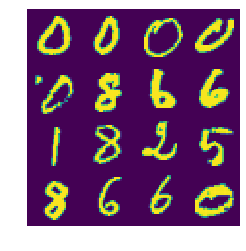

In [14]:
remove_dim = False
pca = False
# latent_dim += 1
k = 2
bsize = min(1024, len(x_train))

# NOTE: currently the train and test sets are combined

# split = int(len(x_train)*0.8)
# x_train, x_val = x_train[:split], x_train[split:]
# y_train, y_val = y_train[:split], y_train[split:]

x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
# g = plot(x_train, y_train)
# g = plot(x_test, y_test)
def plot_dots(x):
    sns.set()
    sns.despine()
    fig, ax = plt.subplots(1)
    ax.scatter(x[:,0], x[:,1], s=100, alpha=.1)
    major_ticks = np.arange(-2, 3, 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    plt.xlim((-2.5208333333, 2.5208333333))
    plt.ylim((-2.5208333333, 2.5208333333))
    
if dataset == 'gaussian_grid':
    g = plot_dots(x_train)
else:
    g = plot(x_train, y_train)

In [15]:
if pca:
    n_clusters = latent_dim + 1
else:
    n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [29]:
from keras.models import model_from_json
if dataset == 'mnist':
    # first embed data
    x_train_ = embed_data(x_all, 'mnist')
    x_test_ = embed_data(x_all, 'mnist')

    input_shape = x_train_.shape[1:]
    y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
    y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
    inputs = {
        'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
        'Labeled': Input(shape=input_shape, name='LabeledInput'),
        'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
        }
    
    pairs_train, dist_train = pairs.create_pairs_from_unlabeled_data(
        x1=x_train_,
        p=None,
        k=2,
        tot_pairs=600000,
        precomputed_knn_path='',
        use_approx=True,
        pre_shuffled=False,
    )
    pairs_val, dist_val = pairs.create_pairs_from_unlabeled_data(
        x1=x_test_,
        p=None,
        k=2,
        tot_pairs=600000,
        precomputed_knn_path='',
        use_approx=True,
        pre_shuffled=False,
    )
    siamese_net = SiameseNet(inputs=inputs, arch=arch, siam_reg=None, y_true=y_true)
    siamese_net.train(pairs_train, dist_train, pairs_val, dist_val,
            lr=1e-3, drop=0.1, patience=10, num_epochs=400, batch_size=1024)
else:
    siamese_net = None

using pretrained embeddings; sanity check, total reconstruction error: 0.008152941685746977
using pretrained embeddings; sanity check, total reconstruction error: 0.008152941685746977
computing k=2 nearest neighbors...
creating pairs...
ks 70000 2 2 2
Iter: 0/70000
Iter: 10000/70000
Iter: 20000/70000
Iter: 30000/70000
Iter: 40000/70000
Iter: 50000/70000
Iter: 60000/70000
computing k=2 nearest neighbors...
creating pairs...
ks 70000 2 2 2
Iter: 0/70000
Iter: 10000/70000
Iter: 20000/70000
Iter: 30000/70000
Iter: 40000/70000
Iter: 50000/70000
Iter: 60000/70000
Epoch 1/400
273/273 [==============================] - 3s 10ms/step - loss: 0.0249 - val_loss: 0.0192
Epoch 2/400
273/273 [==============================] - 2s 7ms/step - loss: 0.0187 - val_loss: 0.0185
Epoch 3/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0176 - val_loss: 0.0180
Epoch 4/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 5/400
273/273 [==========

Epoch 76/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0124
Epoch 77/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0125
Epoch 78/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0124
Epoch 79/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0123
Epoch 80/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0122
Epoch 81/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0125
Epoch 82/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0090 - val_loss: 0.0122
Epoch 83/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0090 - val_loss: 0.0122
Epoch 84/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0090 - val_loss: 0.0124
Epoch 85/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0089

Epoch 156/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0105
Epoch 157/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 158/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 159/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 160/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 161/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 162/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 163/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 164/400
273/273 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 165/400
273/273 [==============================] - 2s 8ms/step - lo

In [30]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
            spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
            n_clusters=n_clusters, affinity='knn', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, siamese_net=siamese_net, 
            x_train=x_train_, have_labeled=len(x_train))

In [31]:
spectral_net.train(
        x_train_, np.zeros_like(x_train_[0:0]), x_test_,
        lr=1e-3, drop=0.1, patience=20, num_epochs=500)

Epoch: 0, loss=108.730422, val_loss=71.474213
Epoch: 1, loss=30.366738, val_loss=13.696856
Epoch: 2, loss=20.846607, val_loss=13.137451
Epoch: 3, loss=19.438660, val_loss=11.471176
Epoch: 4, loss=18.972701, val_loss=12.229064
Epoch: 5, loss=18.658429, val_loss=11.279097
Epoch: 6, loss=18.288775, val_loss=10.897141
Epoch: 7, loss=18.427891, val_loss=11.847356
Epoch: 8, loss=18.210111, val_loss=10.509826
Epoch: 9, loss=18.418405, val_loss=11.951855
Epoch: 10, loss=18.053337, val_loss=11.353736
Epoch: 11, loss=18.104285, val_loss=10.456467
Epoch: 12, loss=18.149666, val_loss=11.196597
Epoch: 13, loss=18.352331, val_loss=11.929064
Epoch: 14, loss=18.194309, val_loss=11.060005
Epoch: 15, loss=17.759632, val_loss=11.038637
Epoch: 16, loss=17.398363, val_loss=11.446059
Epoch: 17, loss=17.891042, val_loss=10.408689
Epoch: 18, loss=17.831509, val_loss=10.571917
Epoch: 19, loss=17.623524, val_loss=10.491577
Epoch: 20, loss=18.145533, val_loss=11.323723
Epoch: 21, loss=17.853543, val_loss=10.5784

(array([108.73042166,  30.36673754,  20.8466066 ,  19.43866046,
         18.97270052,  18.65842927,  18.28877495,  18.42789143,
         18.21011066,  18.41840535,  18.0533375 ,  18.10428543,
         18.14966612,  18.35233083,  18.19430922,  17.75963208,
         17.3983625 ,  17.89104223,  17.83150907,  17.62352394,
         18.14553337,  17.85354257,  17.69141166,  17.71296151,
         18.17917998,  17.63811138,  17.74038598,  17.79340975,
         17.67584439,  17.78324795,  17.83043405,  17.89168876,
         17.75966442,  17.67107213,  17.69715506,  17.62060817,
         17.70014797,  17.87838933,  17.61454304,  17.56034315,
         17.92002661,  17.77225614,  17.90756704,  17.56581168,
         17.74269751,  17.36294673,  17.52102976,  17.02314577,
         17.13844112,  16.92989603,  17.14879903,  17.21553072,
         17.23089521,  16.91987969,  17.32729769,  17.23138236,
         17.23998161,  16.99398756,  17.24894169,  17.33044589,
         16.88704   ,  17.22407858,  17.

<IPython.core.display.Javascript object>


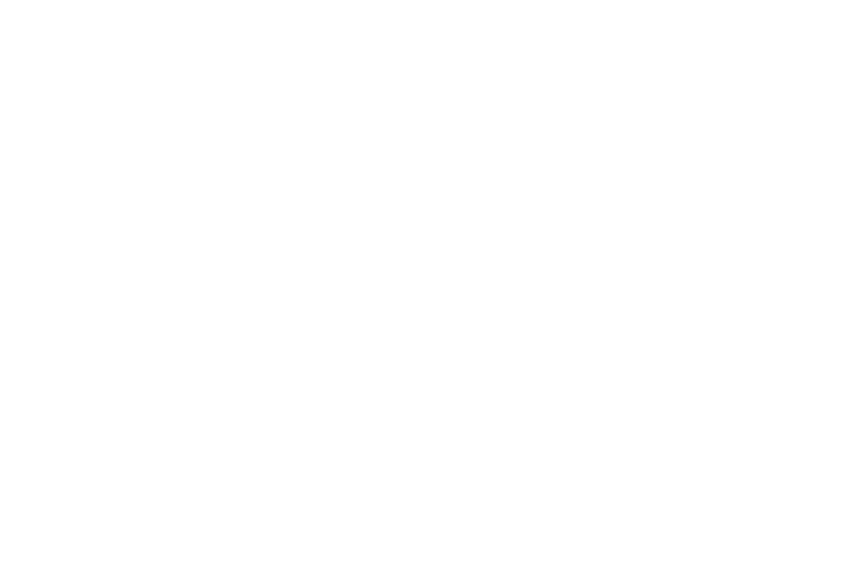

ValueError: 'c' argument has 10000 elements, which is not acceptable for use with 'x' with size 70000, 'y' with size 70000.

<IPython.core.display.Javascript object>


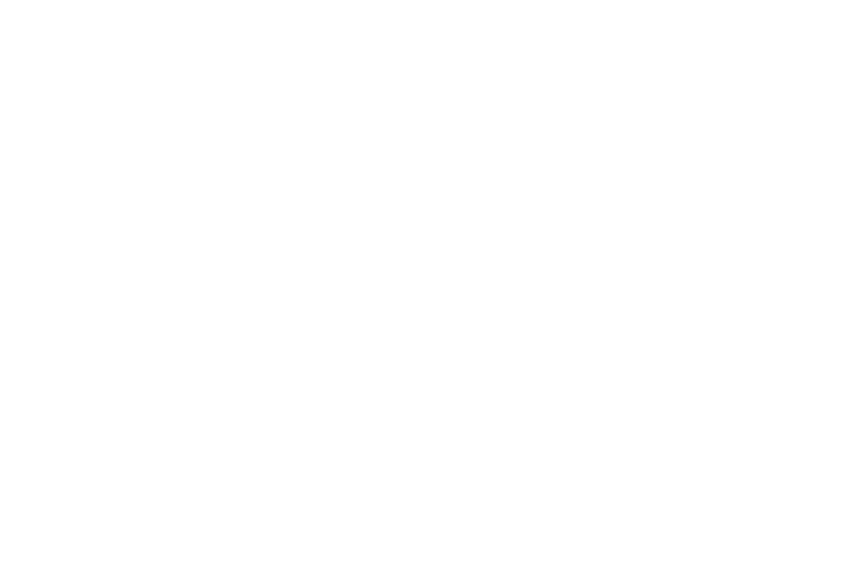

In [32]:
y_pred = spectral_net.predict(x_test_)
g = plot(y_pred[:,:3], y_test.reshape(-1,))
# print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

In [33]:
if 'mnist' in dataset or 'cifar' in dataset:
    from core.util import print_accuracy, get_cluster_sols, LearningHandler, make_layer_list, get_y_preds
    from sklearn.cluster import KMeans
    true_clusters = 10
    # get accuracy and nmi
    kmeans_assignments, km = get_cluster_sols(y_pred, ClusterClass=KMeans, n_clusters=true_clusters, init_args={'n_init':10})
    y_spectralnet, _ = get_y_preds(kmeans_assignments, y_train, true_clusters)
    print_accuracy(kmeans_assignments, y_train, true_clusters)
    from sklearn.metrics import normalized_mutual_info_score as nmi
    nmi_score = nmi(kmeans_assignments, y_train)
    print('NMI: ' + str(np.round(nmi_score, 3)))

confusion matrix: 
[[   1 6843    2    9    0   31    2    2    8    5]
 [3734    1    5  105   22    4   12 3978   12    4]
 [  14   38   58 6775   10    7   50   12   22    4]
 [   9    5   46   73    8    4   55   10 6878   53]
 [  14    4    4   15 6655   39   50   42    0    1]
 [   2   33   37    6   11   88   24    3 1223 4886]
 [   7   32    6    6    4 6771    0    8    6   36]
 [  12    7    3   49   49    0 7123   42    5    3]
 [  27   26 6037   31   48   49   43   30  451   83]
 [  16   47    8    7 3082    5 3622   17  148    6]]
spectralNet accuracy: 0.799
NMI: 0.822


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
# SHOW EMBEDDINGS WITH IM_SCATTER
# _ = imscatter(v[:,1], v[:,2], x_all)
if 'mnist' in dataset or 'cifar' in dataset:
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    %matplotlib inline
    _ = imscatter(y_pred[:,1], y_pred[:,3], x_test, shape=img_shape)

In [ ]:
# now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

if 'mnist' in dataset or 'cifar' in dataset:
    %matplotlib inline
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    _ = imscatter(y_pred_embedded[:,0], y_pred_embedded[:,1], x_test, shape=img_shape)

In [ ]:
# divide k by the difference in batch size
svg_bsize = 1024
svg_k = 1
# svg_k = int(latent_dim / 2)
conv_decoder = True
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], remove_dim=remove_dim, pca=pca, k=svg_k, alpha=1., arch=[x['size'] for x in arch], conv_decoder=conv_decoder)

In [ ]:
p = np.random.permutation(len(x_test))[:100]
y_pred_svg = tf_get([svg.input], [svg.x], x_test[p])[0]
y_pred_svg_embedded = TSNE().fit_transform(y_pred_svg)

if 'mnist' in dataset:
    %matplotlib inline
    _ = imscatter(y_pred_svg_embedded[:,0], y_pred_svg_embedded[:,1], x_test[p], shape=(28, 28))

In [ ]:
y_pred = spectral_net.predict(x_test[p])
# now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
# g = plot(y_pred_embedded[:,:2], y=y_test)

if 'mnist' in dataset:
    %matplotlib inline
    _ = imscatter(y_pred_embedded[:,0], y_pred_embedded[:,1], x_test[p], shape=(28, 28))

In [ ]:
if pca:
    svg.train_pca(x_train, epochs=600)
    svg.pca_layers[0].trainable = False
    svg.pca_layers[1].trainable = False

In [ ]:
if pca:
    y_pred = svg.pc.predict(x_test)
    plt.axis('equal')
    g = plot(y_pred[:,:3], y_test)

In [ ]:
# tf_get([svg.input], [svg.loss], x_test[:10])
# tf_get([svg.input], [svg.decoder_xs[-2]], x_test[:10])[0].shape
svg.train(x_train, epochs=5000, batch_size=svg_bsize)

# ANALYSIS

In [ ]:
%matplotlib

In [ ]:
# pick subset size
n_p = min(1000, len(x_test))
p = np.random.permutation(len(x_test))[:n_p]
x_test_p = x_test[p]
y_test_p = y_test[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train[:10000], normalize_cov=True)
g = plot(x_gen, y_train, x2=x_train, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]
# if dataset == 'gaussian_grid':
#     g = plot_dots(x_gen)
# else:
#     g = plot(x_gen[p], y_train[p_train])

In [ ]:
import imageio
for i, image in enumerate(x_gen):
    imageio.imwrite('/projects/mnist_imgs/vdae_test/{:05d}.png'.format(i), np.array(image).reshape(28,28).astype(np.uint8))

In [ ]:
p = np.random.randint(len(x_gen))
plt.imshow(x_gen[p].reshape(100,80,3))
plt.axis('off')

### RANDOM WALK TESTING

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True) #, normalize_cov=0.5)
y_test_sz = np.mean(f(x_all)[3], axis=1)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(0.5 * y_test_sz)

In [ ]:
import matplotlib.animation

# which space do we want to plot in?
plot_latent = False
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = f(x_arr)
    # plot in latent or original space
    x_ = z_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    
    if x_.shape[1] == 3:
        graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
        ax.view_init(elev=10, azim=num*4)
    elif x_.shape[1] == 2:
        graph.set_offsets(np.c_[x_[:,0], x_[:,1]])
        
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
projection = '3d' if x_.shape[1] == 3 else None
ax = fig.add_subplot(111, projection=projection)
title = ax.set_title('Walk, time=0')

if x_.shape[1] == 3:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=.1)
elif x_.shape[1] == 2:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 180, 
                               interval=200, blit=False)

In [ ]:
import matplotlib.animation as animation
print("saving animation")
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
print("...")
ani.save('im_{}_inv.mp4'.format(dataset), writer=writer)
print("saved")

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, z_mu, z_sigma_v, z_sigma_lam = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

In [ ]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
# x_test_sample = x_train[y_train == 5]
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=2)

In [ ]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p[:15]]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

In [ ]:
p = np.random.permutation(len(p))[:1000]
g, ax = plot(x_arr, x2=x_test[p], label1='predicted', label2='true', alpha2=0.2)
# ax.scatter(x_test_sample[:,0], x_test_sample[:,1], x_test_sample[:,2], s=1000)

In [ ]:
# g = plot(z_mu, x2=f(x_test_sample)[1])
g = plot(z_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr, x2=x_test_sample, s2=1000)

In [ ]:
# COMPUTE BILIP CONSTANT
import annoy
# for each point in x, determine neighborhood in x, and then compute upper and lower constants
def bilip(x, y, k, eps=1e-7):
    # find nearest neighbors
    a = annoy.AnnoyIndex(x.shape[1], 'euclidean')
    for i, x_ in enumerate(x):
        a.add_item(i, x_)
        
    # build nn tree
    a.build(-1)
    
    # compute K
    maxs = []
    for i in range(len(x)):
        x_neighbs, dists = a.get_nns_by_item(i, k+1, include_distances=True)
        x_neighbs, dists = x_neighbs[1:], dists[1:]
        ratio1 = [np.linalg.norm(x[j] - x[i])/np.linalg.norm(y[j] - y[i]) for j in x_neighbs]
        ratio2 = [np.linalg.norm(y[j] - y[i])/np.linalg.norm(x[j] - x[i]) for j in x_neighbs]
        max1, max2 = np.max(ratio1), np.max(ratio2)
        max_ = max(max1, max2) + eps
#         print(ratio1 <= max_, ratio1, max_)
#         print(ratio2 >= 1/max_, ratio2, 1/max_)
        assert np.all(ratio1 <= max_)
        assert np.all(ratio2 >= 1/max_)
        maxs.append(max_)
        
    return maxs

# p = np.random.permutation(len(x_train))[:100]
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True)
Ks = bilip(_x_enc, x_recon, 100)
print(np.mean(Ks), np.std(Ks), np.max(Ks), np.min(Ks))

In [ ]:
g = plot(x_recon, y_train)